In [1]:
# %% [markdown]
# # Prepare Data

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load new dataset
file_path = "Returns_Data_Cleaned.csv"  # Updated file path
df = pd.read_csv(file_path)

# Rename the first column (date column) properly
df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Filter for only the required industries
selected_industries = ["Food", "Smoke", "MedEq", "Drugs", "Telcm"]
df = df[["Dates"] + selected_industries]

# Convert Date column to DateTime format
df = df[df["Dates"].astype(str).str.match(r"^\d{6}$")]  # Keep only YYYYMM format
df["Dates"] = pd.to_datetime(df["Dates"], format="%Y%m")

# Filter data for the required date range
df_filtered = df[(df["Dates"] >= "2019-12-01") & (df["Dates"] <= "2024-11-01")]

# Convert returns from percentage format to decimal (divide by 100)
df_filtered.iloc[:, 1:] = df_filtered.iloc[:, 1:].div(100)

# Set Date as index
df_filtered.set_index("Dates", inplace=True)

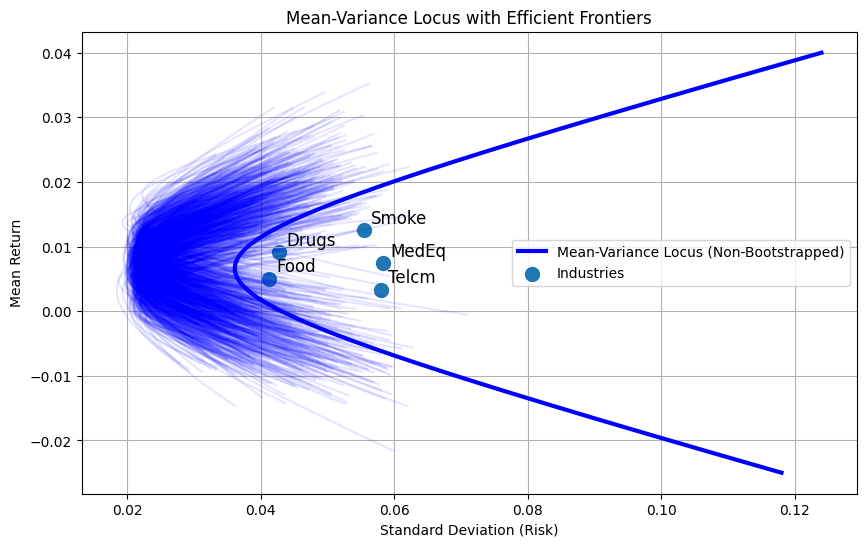

In [2]:
# Step 1: Calculate the mean return for each column (Monthly Average Returns)
mean_returns = df_filtered.mean(axis=0)

# Recalculate monthly variance from the original dataset
monthly_variance = df_filtered.var(axis=0, ddof=1)

# Compute the standard deviation
monthly_std_dev = monthly_variance**0.5

# Step 2: Extract the sample covariance matrix (Σ) and the mean returns vector (μ)
cov_matrix = df_filtered.cov(ddof=1).values  # Covariance matrix Σ (sample statistics)
mean_returns_vector = mean_returns.values    # Vector of expected returns (μ)
ones_vector = np.ones(mean_returns_vector.shape)  # Vector of ones

# Step 3: Calculate A, B, C, and Δ (Delta) using sample statistics
inv_cov_matrix = np.linalg.inv(cov_matrix)     # Σ^-1 (inverse of covariance matrix)
A = ones_vector @ inv_cov_matrix @ ones_vector  # A = 1'Σ^-11
B = ones_vector @ inv_cov_matrix @ mean_returns_vector  # B = 1'Σ^-1μ
C = mean_returns_vector @ inv_cov_matrix @ mean_returns_vector  # C = μ'Σ^-1μ
Delta = (A * C) - (B ** 2)  # Δ = AC - B^2

# Step 4: Compute the Minimum Variance Portfolio (MVP)
mvp_weights = (inv_cov_matrix @ ones_vector) / A
mvp_return = np.dot(mvp_weights, mean_returns_vector)
mvp_std = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)  # Standard deviation of MVP

# Step 5: Define a range of portfolio returns (μ)
target_returns = np.linspace(-0.025, 0.04, 500)  # Independent range for μ (Y-axis values)

# Step 6: Compute λ and γ for the given μ values
lambda_values = (C - target_returns * B) / Delta
gamma_values = (target_returns * A - B) / Delta

# Step 7: Compute the portfolio variances (σ^2)
sigma_squared = []
for lam, gam in zip(lambda_values, gamma_values):
    # Compute weights: w = λ * Σ^-1 * 1 + γ * Σ^-1 * μ
    w = lam * (inv_cov_matrix @ ones_vector) + gam * (inv_cov_matrix @ mean_returns_vector)
    # Compute portfolio variance: σ^2 = w' Σ w
    sigma_squared.append(w.T @ cov_matrix @ w)

# Convert to NumPy array
sigma_squared = np.array(sigma_squared)
efficient_risks = np.sqrt(sigma_squared)  # Standard deviations (Risk)

# Identify the efficient part (upper part of the parabola)
efficient_idx = np.argmax(target_returns > mvp_return)  # Index where frontier becomes efficient
efficient_risks_upper = efficient_risks[efficient_idx:]
target_returns_upper = target_returns[efficient_idx:]



# Define parameters
n_bootstrap = 1000  # Total bootstrap iterations
n_samples = 1000  # Limit to 100 iterations for efficiency
n_months = 60  # Number of months per bootstrap sample
selected_industries = ["Food", "Smoke", "MedEq", "Drugs", "Telcm"]
num_industries = len(selected_industries)

# Perform bootstrap resampling
bootstrap_samples = {
    industry: np.array([
        df_filtered.sample(n=n_months, replace=True)[industry].values
        for _ in range(n_bootstrap)
    ])
    for industry in selected_industries
}

# Compute mean and standard deviation for each bootstrap iteration
bootstrap_means = pd.DataFrame({industry: np.mean(bootstrap_samples[industry], axis=1) for industry in selected_industries})
bootstrap_stds = pd.DataFrame({industry: np.std(bootstrap_samples[industry], axis=1) for industry in selected_industries})

# Compute expected return and risk (mean of bootstrap means and stds)
expected_returns = bootstrap_means.mean(axis=0)
expected_risks = bootstrap_stds.mean(axis=0)

# Select a subset of bootstrap iterations
subset_indices = np.linspace(0, n_bootstrap - 1, n_samples, dtype=int)
subset_means = bootstrap_means.iloc[subset_indices]
subset_stds = bootstrap_stds.iloc[subset_indices]


# Store efficient frontiers for the subset
efficient_frontiers = []

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds for weights (between 0 and 1 for long-only portfolios)
    bounds = [(-10, 10)] * num_industries
    
    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers.append((frontier_returns, frontier_risks))

# Plot mean-variance locus and efficient frontiers
plt.figure(figsize=(10, 6))
plt.plot(efficient_risks, target_returns, label="Mean-Variance Locus (Non-Bootstrapped)", color="blue", linewidth=3)
plt.scatter(expected_risks, expected_returns, marker='o', s=100, label="Industries")

# Plot efficient frontiers for each bootstrap subset iteration
for frontier_returns, frontier_risks in efficient_frontiers:
    plt.plot(frontier_risks, frontier_returns, alpha=0.1, color='blue')

# Annotate each industry
for industry in selected_industries:
    plt.annotate(industry, (expected_risks[industry], expected_returns[industry]), fontsize=12, xytext=(5,5), textcoords='offset points')

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers")
plt.legend()
plt.grid(True)
plt.show()

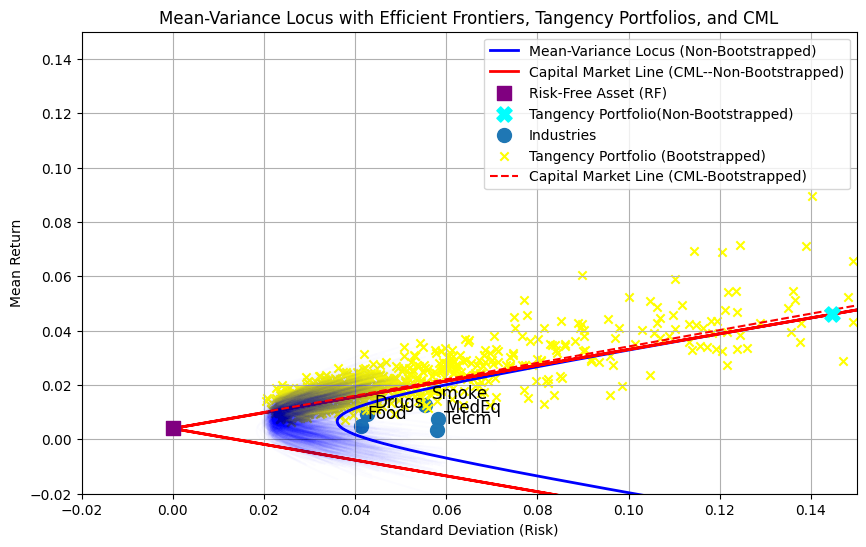

In [3]:

# Define the risk-free rate (0.4% per month)
rf = 0.004  

# Calculate the mean return for each column (Monthly Average Returns)
mean_returns = df_filtered.mean(axis=0)

# Recalculate monthly variance from the original dataset
monthly_variance = df_filtered.var(axis=0, ddof=1)

# Compute the standard deviation
monthly_std_dev = monthly_variance**0.5

# Extract the sample covariance matrix (Σ) and the mean returns vector (μ)
cov_matrix = df_filtered.cov(ddof=1).values  # Covariance matrix Σ (sample statistics)
mean_returns_vector = mean_returns.values    # Vector of expected returns (μ)
ones_vector = np.ones(mean_returns_vector.shape)  # Vector of ones

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute the excess returns (mean returns - risk-free rate)
excess_returns = mean_returns - rf

# Compute the tangency portfolio weights
tangency_weights = inv_cov_matrix @ excess_returns / (ones_vector @ inv_cov_matrix @ excess_returns)

# Compute the expected return and standard deviation of the tangency portfolio
tangency_return_b = np.dot(tangency_weights, mean_returns)
tangency_std_b = np.sqrt(tangency_weights.T @ cov_matrix @ tangency_weights)

# Define a range of portfolio returns for the Mean-Variance Locus
target_returns_b = np.linspace(-0.05, 0.06, 500)

# Compute λ and γ for the given μ values
lambda_values = (C - target_returns_b * B) / Delta
gamma_values = (target_returns_b * A - B) / Delta

# Compute the portfolio variances (σ^2)
sigma_squared_b = []
for lam, gam in zip(lambda_values, gamma_values):
    w = lam * (inv_cov_matrix @ ones_vector) + gam * (inv_cov_matrix @ mean_returns_vector)
    sigma_squared_b.append(w.T @ cov_matrix @ w)

# Convert to NumPy array
sigma_squared_b = np.array(sigma_squared_b)
efficient_risks_b = np.sqrt(sigma_squared_b)  # Standard deviations (Risk)

# Define the Capital Market Line (CML) symmetrically in both directions
cml_risks_b = np.linspace(-max(efficient_risks) * 1.5, max(efficient_risks) * 1.5, 300)
cml_risks_b = np.abs(cml_risks_b)  # Ensure standard deviation remains positive
cml_returns_b = rf + ((tangency_return_b - rf) / tangency_std_b) * np.concatenate((-cml_risks_b[::-1], cml_risks_b))






# Store efficient frontiers and tangency portfolios
efficient_frontiers = []
tangency_points = []

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds for weights (between 0 and 1 for long-only portfolios)
    bounds = [(-10, 10)] * num_industries
    
    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers.append((frontier_returns, frontier_risks))

    # Compute Tangency Portfolio (Max Sharpe Ratio)
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - rf) / portfolio_volatility  # Negative Sharpe to minimize

    result = minimize(negative_sharpe_ratio, initial_guess, bounds=bounds, constraints=constraints)
    
    if result.success:
        tangency_return = np.sum(result.x * mean_returns)
        tangency_risk = np.sqrt(result.x.T @ cov_matrix @ result.x)
        tangency_points.append((tangency_risk, tangency_return))
    else:
        tangency_points.append((np.nan, np.nan))  # Handle failures

# Convert tangency points to arrays
tangency_points = np.array(tangency_points)

# Compute CML endpoints (extend the line beyond tangency portfolio)
cml_risks = np.linspace(0, np.nanmax(tangency_points[:, 0]), 100)
cml_returns = rf + (tangency_points[:, 1].mean() - rf) / tangency_points[:, 0].mean() * cml_risks



# Plot mean-variance locus, efficient frontiers, and tangency portfolios
plt.figure(figsize=(10, 6))

# Plot Mean-Variance Locus as a Single Line
plt.plot(efficient_risks_b, target_returns_b, label="Mean-Variance Locus (Non-Bootstrapped)", color='blue', linewidth=2)

# Plot the Capital Market Line (CML) extended symmetrically
plt.plot(np.concatenate((cml_risks_b[::-1], cml_risks_b)), cml_returns_b, label="Capital Market Line (CML--Non-Bootstrapped)", linestyle="-", color="red", linewidth=2)

# Plot risk-free asset and tangency portfolio
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
plt.scatter(tangency_std_b, tangency_return_b, color="cyan", label="Tangency Portfolio(Non-Bootstrapped)", zorder=3, marker="X", s=120)

plt.scatter(expected_risks, expected_returns, marker='o', s=100, label="Industries")

# Plot efficient frontiers for each bootstrap subset iteration
for frontier_returns, frontier_risks in efficient_frontiers:
    plt.plot(frontier_risks, frontier_returns, alpha=0.01, color='blue')

# Plot Tangency Portfolios
plt.scatter(tangency_points[:, 0], tangency_points[:, 1], marker='x', color='yellow', label="Tangency Portfolio (Bootstrapped)")

# Plot CML
plt.plot(cml_risks, cml_returns, color='red', linestyle="--", label="Capital Market Line (CML-Bootstrapped)")

plt.xlim(-0.02,0.15)
plt.ylim(-0.02,0.15)

# Annotate each industry
for industry in selected_industries:
    plt.annotate(industry, (expected_risks[industry], expected_returns[industry]), fontsize=12, xytext=(5,5), textcoords='offset points')

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers, Tangency Portfolios, and CML")
plt.legend()
plt.grid(True)
plt.show()

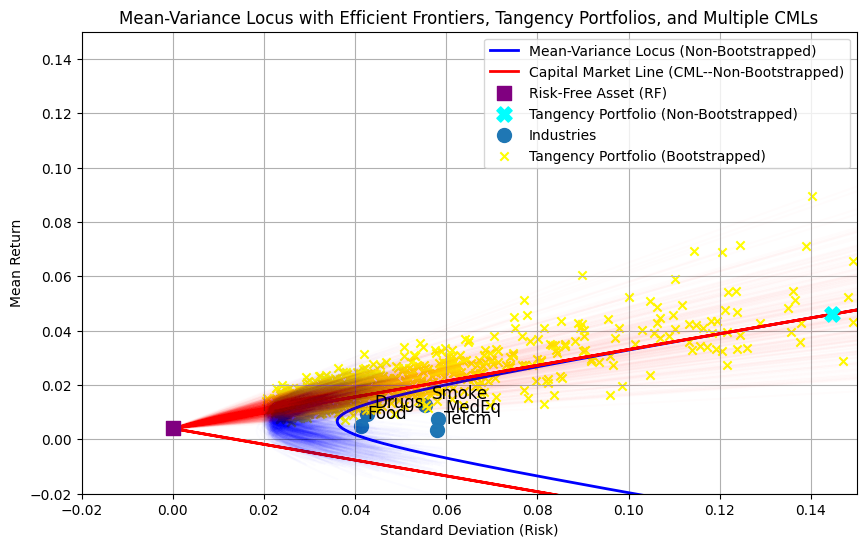

In [4]:


# Define the risk-free rate (0.4% per month)
rf = 0.004  

# Calculate the mean return for each column (Monthly Average Returns)
mean_returns = df_filtered.mean(axis=0)

# Recalculate monthly variance from the original dataset
monthly_variance = df_filtered.var(axis=0, ddof=1)

# Compute the standard deviation
monthly_std_dev = monthly_variance**0.5

# Extract the sample covariance matrix (Σ) and the mean returns vector (μ)
cov_matrix = df_filtered.cov(ddof=1).values  # Covariance matrix Σ (sample statistics)
mean_returns_vector = mean_returns.values    # Vector of expected returns (μ)
ones_vector = np.ones(mean_returns_vector.shape)  # Vector of ones

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute the excess returns (mean returns - risk-free rate)
excess_returns = mean_returns - rf

# Compute the tangency portfolio weights
tangency_weights = inv_cov_matrix @ excess_returns / (ones_vector @ inv_cov_matrix @ excess_returns)

# Compute the expected return and standard deviation of the tangency portfolio
tangency_return_b = np.dot(tangency_weights, mean_returns)
tangency_std_b = np.sqrt(tangency_weights.T @ cov_matrix @ tangency_weights)

# Define a range of portfolio returns for the Mean-Variance Locus
target_returns_b = np.linspace(-0.05, 0.06, 500)

# Compute λ and γ for the given μ values
lambda_values = (C - target_returns_b * B) / Delta
gamma_values = (target_returns_b * A - B) / Delta

# Compute the portfolio variances (σ^2)
sigma_squared_b = []
for lam, gam in zip(lambda_values, gamma_values):
    w = lam * (inv_cov_matrix @ ones_vector) + gam * (inv_cov_matrix @ mean_returns_vector)
    sigma_squared_b.append(w.T @ cov_matrix @ w)

# Convert to NumPy array
sigma_squared_b = np.array(sigma_squared_b)
efficient_risks_b = np.sqrt(sigma_squared_b)  # Standard deviations (Risk)

# Define the Capital Market Line (CML) symmetrically in both directions
cml_risks_b = np.linspace(-max(efficient_risks) * 1.5, max(efficient_risks) * 1.5, 300)
cml_risks_b = np.abs(cml_risks_b)  # Ensure standard deviation remains positive
cml_returns_b = rf + ((tangency_return_b - rf) / tangency_std_b) * np.concatenate((-cml_risks_b[::-1], cml_risks_b))






# Store efficient frontiers and tangency portfolios
efficient_frontiers = []
tangency_points = []
tangency_table = []

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds for weights (between 0 and 1 for long-only portfolios)
    bounds = [(-10, 10)] * num_industries
    
    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers.append((frontier_returns, frontier_risks))

    # Compute Tangency Portfolio (Max Sharpe Ratio)
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - rf) / portfolio_volatility  # Negative Sharpe to minimize

    result = minimize(negative_sharpe_ratio, initial_guess, bounds=bounds, constraints=constraints)
    
    if result.success:
        weights = result.x
        tangency_return = np.sum(weights * mean_returns)
        tangency_risk = np.sqrt(weights.T @ cov_matrix @ weights)
        sharpe_ratio = (tangency_return - rf) / tangency_risk
        tangency_points.append((tangency_risk, tangency_return))
        tangency_table.append([i + 1] + list(weights) + [tangency_return, tangency_risk, sharpe_ratio])
    else:
        tangency_points.append((np.nan, np.nan))  # Handle failures

# Convert tangency points to arrays
tangency_points = np.array(tangency_points)

# Create DataFrame for Tangency Portfolio Table
columns = ["Iteration"] + selected_industries + ["Mean Return", "Standard Deviation", "Sharpe Ratio"]
tangency_df = pd.DataFrame(tangency_table, columns=columns)

# Plot mean-variance locus, efficient frontiers, tangency portfolios, and individual CMLs
plt.figure(figsize=(10, 6))

# Plot Mean-Variance Locus as a Single Line
plt.plot(efficient_risks_b, target_returns_b, label="Mean-Variance Locus (Non-Bootstrapped)", color='blue', linewidth=2)

# Plot the Capital Market Line (CML) extended symmetrically
plt.plot(np.concatenate((cml_risks_b[::-1], cml_risks_b)), cml_returns_b, label="Capital Market Line (CML--Non-Bootstrapped)", linestyle="-", color="red", linewidth=2)

# Plot risk-free asset and tangency portfolio
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
plt.scatter(tangency_std_b, tangency_return_b, color="cyan", label="Tangency Portfolio (Non-Bootstrapped)", zorder=3, marker="X", s=120)



plt.scatter(expected_risks, expected_returns, marker='o', s=100, label="Industries")

# Plot efficient frontiers for each bootstrap subset iteration
for frontier_returns, frontier_risks in efficient_frontiers:
    plt.plot(frontier_risks, frontier_returns, alpha=0.01, color='blue')

# Plot CMLs for each bootstrap iteration
for i in range(n_samples):
    if not np.isnan(tangency_points[i, 0]):  # Ensure valid tangency portfolio
        cml_risks = np.linspace(0, tangency_points[i, 0], 50)
        cml_returns = rf + (tangency_points[i, 1] - rf) / tangency_points[i, 0] * cml_risks
        plt.plot(cml_risks, cml_returns, color='red', alpha=0.01)

# Plot Tangency Portfolios
plt.scatter(tangency_points[:, 0], tangency_points[:, 1], marker='x', color='yellow', label="Tangency Portfolio (Bootstrapped)")

plt.xlim(-0.02,0.15)
plt.ylim(-0.02,0.15)

# Annotate each industry
for industry in selected_industries:
    plt.annotate(industry, (expected_risks[industry], expected_returns[industry]), fontsize=12, xytext=(5,5), textcoords='offset points')

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers, Tangency Portfolios, and Multiple CMLs")
plt.legend()
plt.grid(True)
plt.show()


In [5]:

print(tangency_df)
print("Mean Sharpe Ratio: ",tangency_df["Sharpe Ratio"].mean())

     Iteration      Food      Smoke     MedEq     Drugs      Telcm  \
0            1 -5.203766  10.000000 -4.966518  5.445057  -4.274772   
1            2  0.446517   0.275684 -0.047071  0.567624  -0.242754   
2            3 -0.420038   8.491388  8.555544 -5.626894 -10.000000   
3            4  0.029593   0.231282  0.060863  0.587601   0.090661   
4            5 -0.317341   0.032215  0.603511  0.828986  -0.147371   
..         ...       ...        ...       ...       ...        ...   
995        996 -0.011419   0.257388  0.510680  0.361582  -0.118231   
996        997 -0.928909   0.576584  0.122066  1.059265   0.170994   
997        998  0.511566   0.098827  0.126515  0.351755  -0.088664   
998        999 -3.072789   4.379112  1.097421 -0.803904  -0.599840   
999       1000 -0.492817   0.118139 -0.106877  1.214263   0.267292   

     Mean Return  Standard Deviation  Sharpe Ratio  
0       0.201423            0.682072      0.289446  
1       0.019744            0.038404      0.409959  


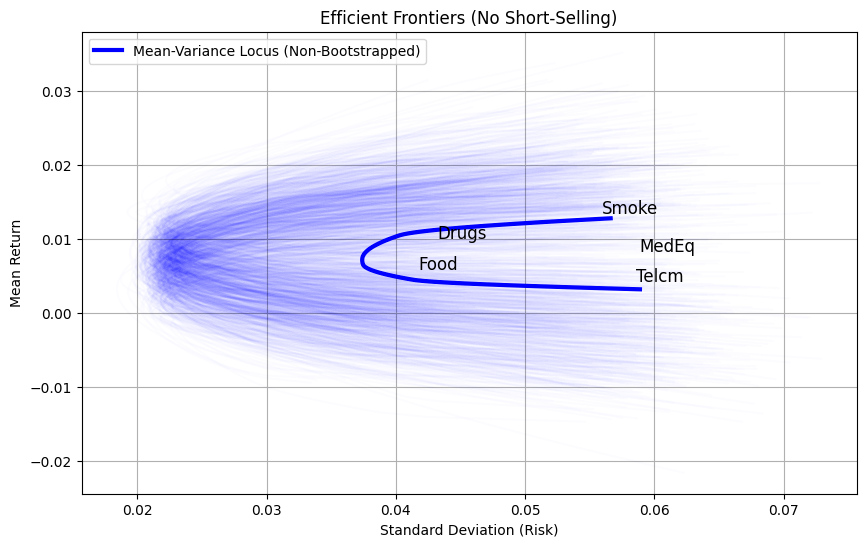

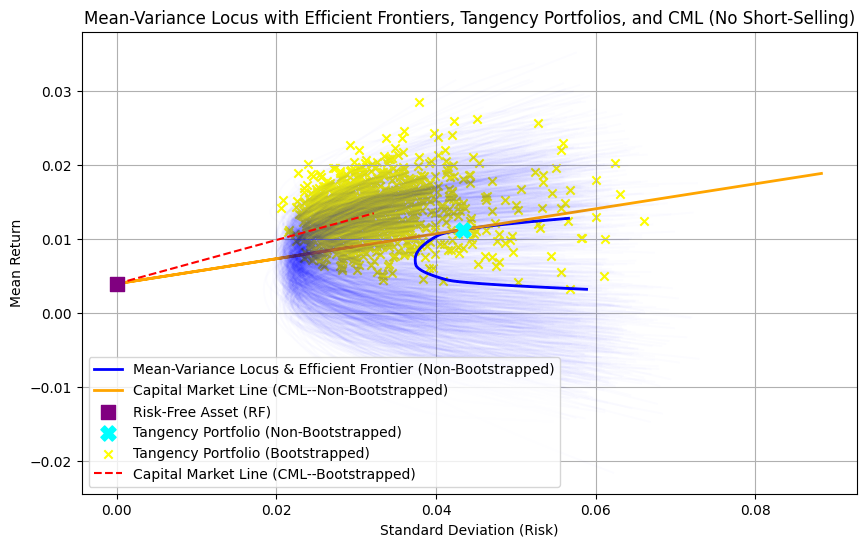

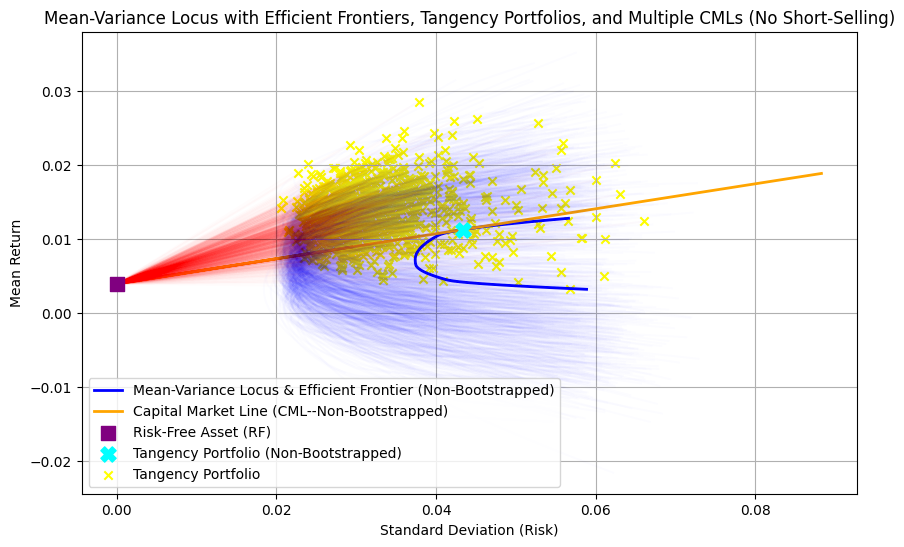

In [6]:
# Calculate the mean return for each column (Monthly Average Returns)
mean_returns = df_filtered.mean(axis=0)

# Recalculate monthly variance from the original dataset
monthly_variance = df_filtered.var(axis=0, ddof=1)

# Compute the standard deviation
monthly_std_dev = monthly_variance**0.5

# Extract the sample covariance matrix (Σ) and the mean returns vector (μ)
cov_matrix = df_filtered.cov(ddof=1).values  # Covariance matrix Σ (sample statistics)
mean_returns_vector = mean_returns.values    # Vector of expected returns (μ)
ones_vector = np.ones(mean_returns_vector.shape)  # Vector of ones

# Ensure num_assets is defined
num_assets = len(mean_returns)

# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Compute the Minimum Variance Portfolio (MVP)
ones_vector = np.ones(num_assets)
inv_cov_matrix = np.linalg.inv(cov_matrix)
mvp_weights = (inv_cov_matrix @ ones_vector) / (ones_vector.T @ inv_cov_matrix @ ones_vector)
min_var_return = np.dot(mvp_weights, mean_returns)  # Define min_var_return
min_var_std = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)  # Compute min variance risk

# Modify the efficient frontier to include short-sale constraints (weights must be non-negative)
bounds = [(0, 1)] * num_assets  # No short-selling allowed

# Generate efficient frontier with short-sale constraints
target_returns_no_short = np.linspace(min(mean_returns) - 0, max(mean_returns) + 0.012857, 200)
efficient_risks_no_short = []

for target in target_returns_no_short:
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target})

    init_guess = np.ones(num_assets) / num_assets  # Ensure initial weights sum to 1

    result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

    efficient_risks_no_short.append(result.fun)

# Identify the efficient part (upper part of the parabola)
efficient_idx_no_short = np.argmax(target_returns_no_short > min_var_return)  # Index where frontier becomes efficient
efficient_risks_upper_no_short = efficient_risks_no_short[efficient_idx_no_short:]
target_returns_upper_no_short = target_returns_no_short[efficient_idx_no_short:]

# Define the cutoff points for the efficient frontier and mean-variance locus
max_return_limit = max(mean_returns["Smoke"], mean_returns["Telcm"])

# Filter the efficient frontier data to stop at the maximum return limit
valid_indices = target_returns_no_short <= max_return_limit
efficient_risks_no_short_limited = np.array(efficient_risks_no_short)[valid_indices]
target_returns_no_short_limited = np.array(target_returns_no_short)[valid_indices]

# Find the new efficient frontier part (upper portion)
efficient_idx_no_short_limited = np.argmax(target_returns_no_short_limited > min_var_return)
efficient_risks_upper_no_short_limited = efficient_risks_no_short_limited[efficient_idx_no_short_limited:]
target_returns_upper_no_short_limited = target_returns_no_short_limited[efficient_idx_no_short_limited:]

# Ensure standard deviations and mean returns have the same size
industry_std_no_short = df_filtered.std()[mean_returns.index]



# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Adjust mean returns to be in excess return form (subtract risk-free rate)
mean_returns_excess = mean_returns - rf

# Generate efficient frontier with short-sale constraints in excess return form
target_returns_no_short_rf_b = np.linspace(min(mean_returns_excess), max(mean_returns_excess) + 0.012857, 200)
efficient_risks_no_short_rf_b = []

# Solve for each target return in excess return space
for target in target_returns_no_short_rf_b:
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns_excess) - target}]

    result = minimize(lambda w: portfolio_volatility(w, cov_matrix), init_guess, method='SLSQP',
                      constraints=constraints, bounds=bounds)

    if result.success:
        efficient_risks_no_short_rf_b.append(result.fun)
    else:
        efficient_risks_no_short_rf_b.append(np.nan)  # Replace failed optimizations with NaN

# Convert lists to numpy arrays and filter out NaN values
efficient_risks_no_short_rf_b = np.array(efficient_risks_no_short_rf_b)
target_returns_no_short_rf_b = np.array(target_returns_no_short_rf_b)

valid_indices_rf_b = ~np.isnan(efficient_risks_no_short_rf_b)
efficient_risks_no_short_rf_b = efficient_risks_no_short_rf_b[valid_indices_rf_b]
target_returns_no_short_rf_b = target_returns_no_short_rf_b[valid_indices_rf_b]

# Define the cutoff points for the efficient frontier
max_return_limit_rf_b = max(mean_returns_excess["Smoke"], mean_returns_excess["Telcm"])

# Filter the efficient frontier data to stop at the maximum return limit
valid_indices_rf_b = target_returns_no_short_rf_b <= max_return_limit_rf_b
efficient_risks_no_short_limited_rf_b = efficient_risks_no_short_rf_b[valid_indices_rf_b]
target_returns_no_short_limited_rf_b = target_returns_no_short_rf_b[valid_indices_rf_b]

# Ensure standard deviations and mean returns have the same size
industry_std_no_short_rf_b = df_filtered.std()[mean_returns.index]

# Compute the Tangency Portfolio using the Sharpe Ratio maximization
def objective_sharpe(w, mean_returns, cov_matrix, rf):
    portfolio_return = np.dot(w, mean_returns)  # Portfolio expected return (absolute return)
    portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))  # Portfolio risk (volatility)
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility  # Sharpe ratio
    return -sharpe_ratio  # Maximize Sharpe Ratio by minimizing its negative

# Constraint: sum of weights = 1
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

# Optimize for the tangency portfolio weights
result_tangency_b = minimize(objective_sharpe, init_guess, args=(mean_returns, cov_matrix, rf), 
                           bounds=bounds, constraints=constraints)

# Extract optimal weights and compute tangency portfolio return and risk
if result_tangency_b.success:
    optimal_weights = result_tangency_b.x
    tangency_return_b = np.dot(optimal_weights, mean_returns)  # Tangency Portfolio return (absolute return)
    tangency_std_b = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))  # Tangency Portfolio risk

# Generate the extended Capital Market Line (CML)
cml_risk_b = np.linspace(-max(efficient_risks_no_short_limited_rf_b) * 0.5, max(efficient_risks_no_short_limited_rf_b) * 1.5, 300)  
cml_risk_b = np.abs(cml_risk_b)  # Ensure standard deviation remains positive
cml_return_b = rf + ((tangency_return_b - rf) / tangency_std_b) * cml_risk_b  # CML equation with correct RF intercept



# Store efficient frontiers and tangency portfolios for no short-selling case
efficient_frontiers_no_short = []
tangency_points_no_short = []
tangency_table_no_short = []

# Set non-negative weights constraint (no short-selling)
bounds_no_short = [(0, 1)] * num_industries  # Weights must be between 0 and 1

for i in range(n_samples):
    mean_returns = subset_means.iloc[i].values
    std_devs = subset_stds.iloc[i].values
    cov_matrix = np.diag(std_devs ** 2)  # Approximate covariance as diagonal matrix

    # Define portfolio volatility function
    def portfolio_volatility(weights):
        return np.sqrt(weights.T @ cov_matrix @ weights)

    # Constraints: Sum of weights = 1 (fully invested portfolio)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Initial guess (equal weights)
    initial_guess = np.ones(num_industries) / num_industries

    # Efficient frontier computation (no short-selling)
    frontier_returns = np.linspace(min(mean_returns), max(mean_returns), 50)
    frontier_risks = []

    for target_return in frontier_returns:
        constraints_with_return = [
            {'type': 'eq', 'fun': lambda w: np.sum(w * mean_returns) - target_return},
            constraints
        ]
        result = minimize(portfolio_volatility, initial_guess, bounds=bounds_no_short, constraints=constraints_with_return)
        frontier_risks.append(result.fun if result.success else np.nan)

    efficient_frontiers_no_short.append((frontier_returns, frontier_risks))

    # Compute Tangency Portfolio (Max Sharpe Ratio, no short-selling)
    def negative_sharpe_ratio(weights):
        portfolio_return = np.sum(weights * mean_returns)
        portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)
        return -(portfolio_return - rf) / portfolio_volatility  # Negative Sharpe to minimize

    result = minimize(negative_sharpe_ratio, initial_guess, bounds=bounds_no_short, constraints=constraints)
    
    if result.success:
        weights = result.x
        tangency_return = np.sum(weights * mean_returns)
        tangency_risk = np.sqrt(weights.T @ cov_matrix @ weights)
        sharpe_ratio = (tangency_return - rf) / tangency_risk
        tangency_points_no_short.append((tangency_risk, tangency_return))
        tangency_table_no_short.append([i + 1] + list(weights) + [tangency_return, tangency_risk, sharpe_ratio])
    else:
        tangency_points_no_short.append((np.nan, np.nan))  # Handle failures

# Convert tangency points to arrays
tangency_points_no_short = np.array(tangency_points_no_short)

# ----- Graph 1: Efficient Frontiers Only -----
plt.figure(figsize=(10, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line)
plt.plot(efficient_risks_no_short_limited, target_returns_no_short_limited, 
         label="Mean-Variance Locus (Non-Bootstrapped)", color="blue", linewidth=3)


for frontier_returns, frontier_risks in efficient_frontiers_no_short:
    plt.plot(frontier_risks, frontier_returns, alpha=0.01, color='blue')

# Annotate each industry
for industry in selected_industries:
    plt.annotate(industry, (expected_risks[industry], expected_returns[industry]), fontsize=12, xytext=(5,5), textcoords='offset points')


plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Efficient Frontiers (No Short-Selling)")
plt.legend()
plt.grid(True)
plt.show()

# ----- Graph 2: Add One CML + Tangency Portfolios -----
plt.figure(figsize=(10, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line with RF Adjustment)
plt.plot(efficient_risks_no_short_limited_rf_b, target_returns_no_short_limited_rf_b + rf, 
         label="Mean-Variance Locus & Efficient Frontier (Non-Bootstrapped)", color="blue", linewidth=2)

# Capital Market Line (CML) fully extended
plt.plot(cml_risk_b, cml_return_b, label="Capital Market Line (CML--Non-Bootstrapped)", color="orange", linewidth=2)

# Plot risk-free asset and tangency portfolio
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
# Plot Tangency Portfolio at the optimal risk-return tradeoff
plt.scatter(tangency_std_b, tangency_return_b, color="cyan", label="Tangency Portfolio (Non-Bootstrapped)", zorder=3, marker="X", s=120)


for frontier_returns, frontier_risks in efficient_frontiers_no_short:
    plt.plot(frontier_risks, frontier_returns, alpha=0.01, color='blue')
plt.scatter(tangency_points_no_short[:, 0], tangency_points_no_short[:, 1], marker='x', color='yellow', label="Tangency Portfolio (Bootstrapped)")
cml_risks = np.linspace(0, np.nanmean(tangency_points_no_short[:, 0]), 100)
cml_returns = rf + (np.nanmean(tangency_points_no_short[:, 1]) - rf) / np.nanmean(tangency_points_no_short[:, 0]) * cml_risks
plt.plot(cml_risks, cml_returns, color='red', linestyle="--", label="Capital Market Line (CML--Bootstrapped)")
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers, Tangency Portfolios, and CML (No Short-Selling)")
plt.legend()
plt.grid(True)
plt.show()

# ----- Graph 3: Add All CMLs + Tangency Portfolios -----
plt.figure(figsize=(10, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line with RF Adjustment)
plt.plot(efficient_risks_no_short_limited_rf_b, target_returns_no_short_limited_rf_b + rf, 
         label="Mean-Variance Locus & Efficient Frontier (Non-Bootstrapped)", color="blue", linewidth=2)

# Capital Market Line (CML) fully extended
plt.plot(cml_risk_b, cml_return_b, label="Capital Market Line (CML--Non-Bootstrapped)", color="orange", linewidth=2)

# Plot risk-free asset and tangency portfolio
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
# Plot Tangency Portfolio at the optimal risk-return tradeoff
plt.scatter(tangency_std_b, tangency_return_b, color="cyan", label="Tangency Portfolio (Non-Bootstrapped)", zorder=3, marker="X", s=120)


for frontier_returns, frontier_risks in efficient_frontiers_no_short:
    plt.plot(frontier_risks, frontier_returns, alpha=0.01, color='blue')
for i in range(n_samples):
    if not np.isnan(tangency_points_no_short[i, 0]):  # Ensure valid tangency portfolio
        cml_risks = np.linspace(0, tangency_points_no_short[i, 0], 50)
        cml_returns = rf + (tangency_points_no_short[i, 1] - rf) / tangency_points_no_short[i, 0] * cml_risks
        plt.plot(cml_risks, cml_returns, color='red', alpha=0.01)
plt.scatter(tangency_points_no_short[:, 0], tangency_points_no_short[:, 1], marker='x', color='yellow', label="Tangency Portfolio")
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontiers, Tangency Portfolios, and Multiple CMLs (No Short-Selling)")
plt.legend()
plt.grid(True)
plt.show()

# ----- Table: Tangency Portfolio Details -----
columns = ["Iteration"] + selected_industries + ["Mean Return", "Standard Deviation", "Sharpe Ratio"]
tangency_df_no_short = pd.DataFrame(tangency_table_no_short, columns=columns)

In [7]:
print(tangency_df_no_short)
print("Mean Sharpe Ratio: ",tangency_df_no_short["Sharpe Ratio"].mean())

     Iteration          Food     Smoke         MedEq         Drugs  \
0            1  0.000000e+00  0.747043  0.000000e+00  2.529571e-01   
1            2  3.455218e-01  0.213907  0.000000e+00  4.405714e-01   
2            3  1.541175e-16  0.479094  5.209055e-01  0.000000e+00   
3            4  2.966471e-02  0.231260  6.073178e-02  5.876766e-01   
4            5  6.301183e-18  0.021711  4.115613e-01  5.667276e-01   
..         ...           ...       ...           ...           ...   
995        996  0.000000e+00  0.228366  4.523938e-01  3.192403e-01   
996        997  3.374695e-17  0.298675  6.346114e-02  5.480936e-01   
997        998  4.701800e-01  0.090125  1.166277e-01  3.230675e-01   
998        999  0.000000e+00  0.800478  1.995216e-01  2.593095e-17   
999       1000  0.000000e+00  0.073584  2.311754e-17  7.597661e-01   

            Telcm  Mean Return  Standard Deviation  Sharpe Ratio  
0    1.506596e-17     0.010345            0.037046      0.171282  
1    1.160096e-17     0.0